In [ ]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install geocoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Downloading all bonds ever owned in CSPP

TODO: to .py file

In [2]:
import requests, datetime
from functions import downloadECBBonds

In [3]:
downloadECBBonds.download_ECB_Bonds()

# ECB green bonds that are listed on Euronext stock exchange 

In [ ]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
euronext_greenbonds

In [ ]:
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
euronext_greenbond_isin

In [ ]:
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]
ecbgreenbonds

TODO: calculate percentage green before and after 2020

# Sector Analysis

## Get all sector data from PermID

In [ ]:
# Requirements
from OpenPermID import OpenPermID
import Levenshtein
import geocoder

In [ ]:
# Gain access to the permid database
opid = OpenPermID()
opid.set_access_token("r95vEAhvmucG8iNGtsP17hjbgUGMhz4j")

In [ ]:
holdingsECB = pd.read_csv("data/holdingsECB.csv",sep=";")
holdingsEikon = pd.read_csv("data/holdingsECBGeneralInfo.txt",sep="\t").iloc[:, :-3]
holdingsEikon.rename(columns = {'Legal Entity ID': 'LEI'}, inplace = True)

companies_LEI = holdingsECB[['ISIN', 'ISSUER']].merge(holdingsEikon[['ISIN', 'LEI']], how = 'left', on = 'ISIN')
companies_LEI = companies_LEI[['ISSUER', 'LEI']].drop_duplicates('ISSUER')
companies_LEI

In [ ]:
LEIs = holdingsEikon['LEI'].dropna().astype('string').unique()

lei_input = pd.DataFrame({})
localID = 1
for lei in LEIs:
    lei_input = lei_input.append(pd.DataFrame({'LocalID': localID, 'Standard Identifier': 'LEI:' + lei}, index = [0]))
    localID += 1
    
while True:
    try:    
        lei_df, err = opid.match(lei_input)
        break
    except JSONDecodeError:
        continue

lei_mappings = pd.DataFrame({})
lei_mappings['LEI'] = pd.Series(LEIs)
lei_mappings['CompanyName'] = lei_df['Match OrgName']
lei_mappings = pd.concat([lei_mappings, lei_df['Match OpenPermID'].astype('string').apply(lambda x: x.split('/')[-1])], axis = 1)
lei_mappings.rename(columns = {'Match OpenPermID': 'PermID'}, inplace = True)
lei_mappings

In [ ]:
permids = lei_mappings.PermID.astype('string')
sector_lookups = pd.DataFrame({})
unsuccessful_lookups = []

for permid in permids:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        try:
            count = count - 1
            output, err = opid.lookup(permid)
        except JSONDecodeError:
            continue
    if err != None:
        unsuccessful_lookups.append(permid)
        continue

    if "hasPrimaryBusinessSector" in output.columns:
        sector_info = output.loc[:, 'hasPrimaryBusinessSector': 'hasPrimaryIndustryGroup']
        sector_info = sector_info.applymap(lambda x: x.split('/')[-1])
    if "isIncorporatedIn" in output.columns:
        loc_info = output.loc[:, 'isIncorporatedIn': 'isDomiciledIn']
        loc_info = loc_info.applymap(lambda x: x.split('/')[-2])
        
    row = pd.DataFrame({'PermID': [permid]})
    row = pd.concat([row, sector_info], axis = 1) if type(sector_info) == pd.DataFrame else row
    row = pd.concat([row, loc_info], axis = 1) if type(loc_info) == pd.DataFrame else row
    sector_lookups = sector_lookups.append(row)
    
    sector_info, loc_info = None, None

sector_lookups

In [ ]:
sector_lookups_converted = sector_lookups.copy()
sector_types = sector_lookups.columns[1:4]
for sector_type in sector_types:
    sector_dict = {}
    sectors = sector_lookups.loc[:, sector_type].dropna().astype('string').unique()
    for sector in sectors:
        while True:
            try:
                output, err = opid.lookup(sector)
                break
            except JSONDecodeError:
                continue
        sector_dict[sector] = output.iloc[0, -1]
    sector_lookups_converted[sector_type] = sector_lookups[sector_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else sector_dict[x])

loc_types = sector_lookups.columns[4:]
for loc_type in loc_types:
    loc_dict = {}
    locs = sector_lookups.loc[:, loc_type].dropna().astype('string').unique()
    for loc in locs:
        g = geocoder.geonames(loc, method='details', key='brian1998716')
        loc_dict[loc] = g.address
    sector_lookups_converted[loc_type] = sector_lookups[loc_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else loc_dict[x])

sector_lookups_converted

In [ ]:
sector_mappings = lei_mappings.merge(sector_lookups_converted, how = 'left', on = 'PermID')
sector_mappings = companies_LEI.merge(sector_mappings, how = 'left', on = 'LEI')
sector_mappings

In [ ]:
sector_mappings.count()

## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

In [ ]:
import matplotlib.pyplot as plt # TODO: add to requirements if used

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (pct > 2.4):
            return '{p:.2f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

def get_all_sectors(sector_type):
    sector_mappings['number']=1 # TODO: count them in a cleaner way
    sectors = sector_mappings[[sector_type, 'number']].groupby([sector_type]).sum()
    sectors = sectors.sort_values("number", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    return sectors
    
def make_pie_chart(column_name):
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(111)

    sectors = get_all_sectors(column_name)
    
    sectors.plot(kind='pie', y='number', ax=ax, autopct=make_autopct(sectors['number']), fontsize=12, legend=False, rotatelabels=True, pctdistance=0.8)
    plt.axis("off")
    plt.title(column_name+"\n\n\n")

In [ ]:
make_pie_chart('hasPrimaryBusinessSector')

In [ ]:
make_pie_chart('hasPrimaryEconomicSector')

In [ ]:
# make_pie_chart('hasPrimaryIndustryGroup') # TODO: Fix Error

## Which industries and sectors are green?

Get all the emission data on sectors in the European Union.

In [ ]:
# Data from kaggle: https://www.kaggle.com/cathetorres/ghg-emissions-by-country-and-economic-sector
historical_emissions = pd.read_csv("data/Sector_data/historical_emissions.csv")

In [ ]:
# Filter out all the sectors from the EU for which kaggle has emission data
historical_emissions_EU = historical_emissions[historical_emissions["Country"]== "European Union (27)"]

def get_all_sectors_EU(sector_type): #TODO: make function one with previous
    historical_emissions_EU["number"]=1 # TODO: count them in a cleaner way
    sectors_EU = historical_emissions_EU[[sector_type, "number"]].groupby([sector_type]).sum()
    sectors_EU = sectors_EU.sort_values("number", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    return sectors_EU

all_sectors_EU = get_all_sectors_EU("Sector")
print(all_sectors_EU)

Map these sectors with the ones in which ECB invested



In [ ]:
# Set perfect matches: TODO work with regex or text analysis?
primary_business_sector = get_all_sectors("hasPrimaryBusinessSector")
primary_business_sector["EU_Sector_Name"] = "Other" # Default sector is "Other"
for i in range(0, primary_business_sector.shape[0]):
        if primary_business_sector.index[i] in all_sectors_EU.index:
            primary_business_sector["EU_Sector_Name"][i]=primary_business_sector.index[i]
            
# Manually append list, those in comments will get the sector "Other"

# primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Banking & Investment Services"]=""
# primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Utilities"]=""
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Real Estate"]="Building"
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Industrial & Commercial Services"]="Industrial Processes and Product Use" # Or "Industrial Processes"
# primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Investment Holding Companies"]=""
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Chemicals"]="Fugitive Emissions" # TODO: Is this true?
# primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Insurance"]=""
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Energy - Fossil Fuels"]="Total fossil fuels and cement"
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Telecommunications Services"]=""
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Automobiles & Auto Parts"]="Manufacturing/Construction" # TODO: Is this true?
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Industrial Goods"]="Industrial Processes and Product Use" # Or "Industrial Processes"
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Technology Equipment"]="Manufacturing/Construction" # TODO: Is this true?
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Cyclical Consumer Services"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Cyclical Consumer Products"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Food & Beverages"]="test" # Agriculture?
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Mineral Resources"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Pharmaceuticals & Medical Research"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Applied Resources"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Healthcare Services & Equipment"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Food & Drug Retailing"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Software & IT Services"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Retailers"]=""
#primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Collective Investments"]=""
primary_business_sector["EU_Sector_Name"][primary_business_sector.index == "Consumer Goods Conglomerates"]="Industrial Processes and Product Use"
primary_business_sector

TODO: analyse the emission known for every sector and decide on a threshold to call some of them green

TODO: find a way to calculate which percentage is green and conlude whether this is more than random

TODO: finish as professor told

# Read all the Eikon data

In [2]:
eikon_data_folder = "data/"
eikon_data_environment = pd.read_csv(eikon_data_folder+"holdingsECBEnvironment.txt",sep="\t")
# TODO: remove right, empty columns from data frame
eikon_data_general = pd.read_csv(eikon_data_folder+"holdingsECBGeneralInfo.txt",sep="\t")

In [4]:
eikon_data_complete = eikon_data_general.merge(eikon_data_environment, "left", "ISIN") #append environment
eikon_data_complete.rename(columns={'CO2.1': 'CO2_1'}, inplace=True) #changed column name to prevent syntax errors 

read all data from eligible universe

In [5]:
eligible_environment = pd.read_csv(eikon_data_folder+"eligibleUniverseEnvironment.txt",sep="\t")
eligible_general = pd.read_csv(eikon_data_folder+"eligibleUniverseGeneralInfo.txt",sep="\t")

In [6]:
eligible_complete = eligible_general.merge(eligible_environment, "left", "ISIN")
eligible_complete.rename(columns={"Issuer": "ISSUER"}, inplace=True)

Compare how many bonds from the eligible universe the ECB bought.

In [7]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


__More companies mapped in Eikon database (370 vs 339), but more industries mapped in PermID database (313 vs 158).__

Read the dates

In [49]:
holdings_date_info = pd.read_csv(eikon_data_folder+"holdingsECBDates.csv",sep="\t")
holdings_date_info["Date"] = pd.to_datetime(holdings_date_info["Date"])

Timestamp('2017-06-23 00:00:00')

In [97]:
# make a dictionary: key = ISSUER, value is list of years in which it was bought
years_issuer_bought = {}
for index,row in holdings_date_info.merge(eikon_data_general[["ISSUER","ISIN"]],"left","ISIN").iterrows():
    issuer = row["ISSUER"]
    year = row["Date"].year
    if issuer in years_issuer_bought:
        if year not in years_issuer_bought[issuer]:
            years_issuer_bought[issuer].append(year)
    else:
        years_issuer_bought[issuer] = [year]

# convert dictionary to pd.DataFrame
matrixData = []
for issuer, years in years_issuer_bought.items():
    item = [issuer] + [years]
    matrixData.append(item)
years_issuer_bought = pd.DataFrame(matrixData,columns=["ISSUER","YEARS"])

# Environmental Analysis

## CO2 Data/Graphs

(Maarten): I think everything here can be deleted, as we're not able to make a comparison between the holdings and the eligible universe

### Spaghetti plot CO$_2$

In [ ]:
co2_data = eikon_data_complete[["ISSUER", "CO2", "CO2_1"]] #compnay name and CO2 subset 
company_co2_data = co2_data.drop_duplicates(subset= ["ISSUER"]) #Unique company name subset 
company_co2_data = company_co2_data[(company_co2_data.CO2 != '0') & (company_co2_data.CO2_1 != '0')] #not null value for CO2
company_co2_data = company_co2_data.reset_index() #resets index
company_co2_data = company_co2_data.drop(columns=["index"]) #removes extra column
company_co2_data = company_co2_data.replace(to_replace = '[,]', value ='.', regex=True) #making decimal points legible
company_co2_data['CO2'] =company_co2_data['CO2'].astype(float) #converting numbers to floats 
company_co2_data['CO2_1'] =company_co2_data['CO2_1'].astype(float)

#overall slope increase or decrease 
slopes = company_co2_data['CO2_1'] - company_co2_data['CO2']
slopes.sum() #shows an overall decrease in total emissions **Could cluster by sector. Hard to do anything else with 2 data points*


#making data easier to graph 
co2graph_data = company_co2_data[["CO2", "CO2_1"]]
co2graph_data = co2graph_data.transpose()
co2graph_data.insert(0, "x", [0, 1], True)


plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

#spaghetti plot of CO2 emissions 
plt.figure(figsize=(20,20))
for column in co2graph_data.drop(columns=["x"], axis=1):
    plt.plot(co2graph_data["x"], co2graph_data[column], marker='', linewidth=1, alpha=0.9)
    
plt.show()



### Histogram change in CO$_2$

In [ ]:
plt.hist(x=slopes, bins=7,alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(r'Histogram of the change in nomalized CO$_2$ emission during the CSPP')
plt.show()

### emission of 2021 as a function of the emission in 2015

In [ ]:
plt.plot(company_co2_data["CO2"],company_co2_data["CO2_1"],'o')
plt.title("emission of 2021 as a function of the emission in 2015", size=15)
plt.xlabel("emission in 2015", size=15)
plt.ylabel("emission in 2021",size=15)
plt.show()

Make a linear fit through for this graph (see github of course: data analytics > radient_descent)

In [ ]:
from sklearn.linear_model import LinearRegression
# We will use the module Linear Regression of sklearn to perform the analysis
# Initialize the model
ols = LinearRegression()
# Fit the model to the data
ols.fit(company_co2_data["CO2"].values.reshape(-1, 1),company_co2_data["CO2_1"])

print('Fit is of the form:',np.round(ols.intercept_,3),'+',np.round(ols.coef_[0],3),'x')

As the slope is slightly below one, we can conclude that in general, the normalized CO$_2$ emission decreases.

In [ ]:
plt.figure(figsize=(10,5))

# plot of data
plt.plot(company_co2_data["CO2"],company_co2_data["CO2_1"],'o',label="data")

# plot of fit
x = np.arange(0,max((company_co2_data["CO2"])+100))
y = ols.intercept_ + ols.coef_[0]*x
plt.plot(x,y,'r-',label="fit")

# making a nice figure
plt.title("emission of 2021 as a function of the emission in 2015", size=15)
plt.xlabel("emission in 2015", size=15)
plt.ylabel("emission in 2021",size=15)
plt.legend(fontsize="15")

plt.show()

## ESG data/plots

Function for cleaning the ESG data

In [8]:
def cleaning_esg_data(df):
    column_names_esg_company_data = ["ISSUER", "ESG Score 2015", "ESG Score 2016", "ESG Score 2017", 
                                "ESG Score 2018", "ESG Score 2019", "ESG Score 2020", 
                                "ESG Score 2021"]
    #started cleaning data as above 
    esg_data = df[column_names_esg_company_data]
    esg_company_data = esg_data.drop_duplicates(subset= ["ISSUER"])
    esg_company_data = esg_company_data.replace(to_replace = '[,]', value ='.', regex=True)

    # replace zeros with nans, as these are easier to replace
    esg_company_data = esg_company_data.replace(to_replace = '0', value = np.nan) 

    # remove rows with no data for ESG score
    esg_company_data.dropna(axis=0, how='all', 
                            subset=column_names_esg_company_data[1:8], inplace=True)

    #converting all numbers to floats 
    for column_name in column_names_esg_company_data[1:8]:
        esg_company_data[column_name] = esg_company_data[column_name].astype(float)

    # interpolate data that is missing
    esg_company_data.iloc[:,1:] = esg_company_data.iloc[:,1:].interpolate(method='linear', axis=1, limit_direction='both',
                                                                          inplace=False)
    #TODO: If we want to keep this apart, we can make a new variable holding the filled in dataframe

    # reset the indexes
    esg_company_data = esg_company_data.reset_index()
    esg_company_data = esg_company_data.drop(columns=["index"])
    
    return esg_company_data

In [101]:
esg_company_data_eligible = cleaning_esg_data(eligible_complete)
esg_company_data_holdings = cleaning_esg_data(eikon_data_complete)

### Spaghetti plot ESG Scores

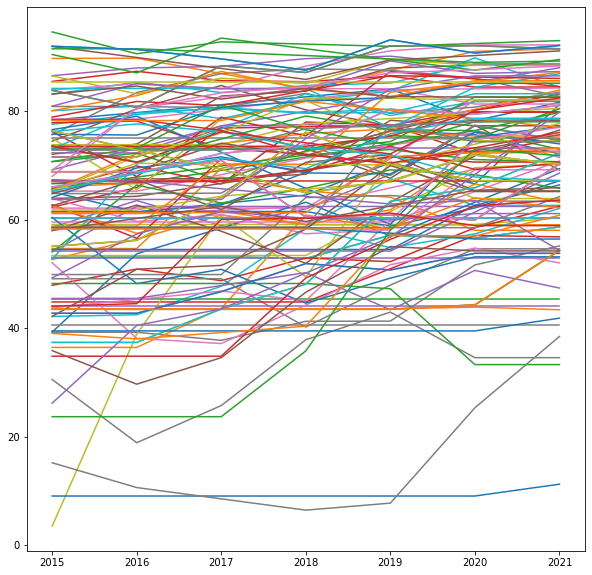

In [10]:
plt.figure(figsize=(10,10))
years = range(2015,2022)
for index,row in esg_company_data_holdings.iterrows():
    plt.plot(years,row[1:8])
plt.show()

### Some Descriptive Statistics

In [11]:
esg_company_data_holdings.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,62.156790,63.167049,64.976403,66.013230,68.266407,70.024616,71.151779
std,16.832183,16.563830,16.408036,15.688833,15.173085,14.653935,14.052443
min,3.485178,9.035207,8.511902,6.428276,7.725643,9.035207,11.218529
25%,52.976506,53.189321,54.312270,57.651837,58.623800,60.340022,62.485910
50%,63.953770,65.422763,66.917698,67.784729,70.247082,72.286777,72.441233
75%,73.817561,73.800401,76.984623,77.969904,79.110492,80.353174,82.051805
max,94.681897,91.568308,93.545750,92.430724,93.230124,92.542586,93.072831


In [12]:
esg_company_data_eligible.describe()

,ESG Score 2015,ESG Score 2016,ESG Score 2017,ESG Score 2018,ESG Score 2019,ESG Score 2020,ESG Score 2021
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,62.069953,63.995237,66.128372,67.472692,69.621426,70.497905,71.550933
std,19.055657,19.225019,17.977814,17.202404,16.394652,16.308647,15.747909
min,7.245926,14.533691,17.422135,18.792800,20.163466,25.318226,19.520247
25%,52.978833,55.010988,57.931346,59.222782,60.930691,64.037336,65.359909
50%,65.615280,67.266580,68.065178,69.602814,73.567484,73.959197,74.231511
75%,75.062302,78.451767,80.186580,81.979221,82.517499,82.742138,82.860713
max,91.992754,91.741976,91.769690,94.327360,93.230124,92.869364,92.869364


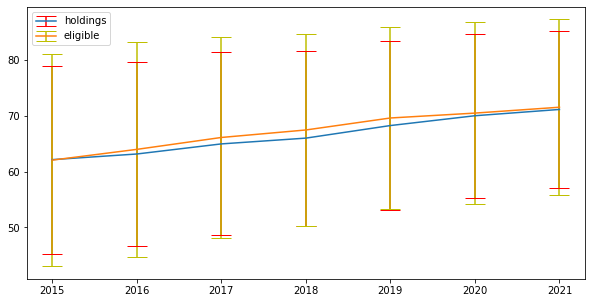

In [13]:
plt.figure(figsize=(10,5))

years = range(2015,2022)

mean_holdings = esg_company_data_holdings.mean().values
error_holdings = esg_company_data_holdings.std().values

mean_eligible = esg_company_data_eligible.mean().values
error_eligible = esg_company_data_eligible.std().values

plt.errorbar(years, mean_holdings, yerr=error_holdings, ecolor='r', capsize=10, label="holdings")

plt.errorbar(years, mean_eligible, yerr=error_eligible, ecolor='y', capsize=10, label="eligible")

plt.legend()

plt.show()

In this figure, we can clearly see that the average ESG-score of the companies increases.

<AxesSubplot:>

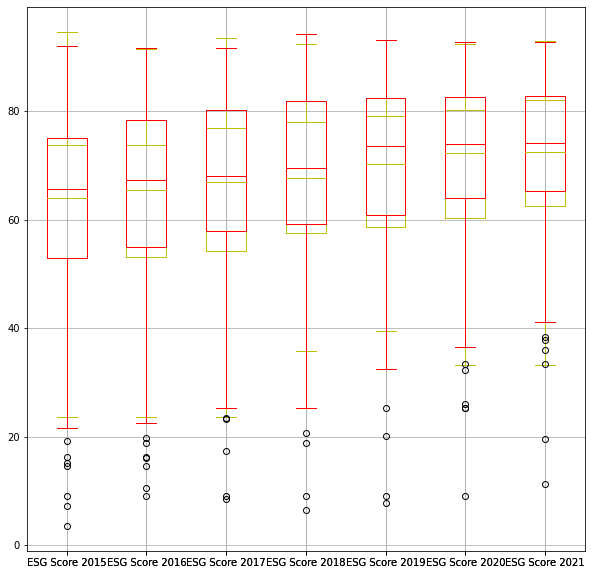

In [14]:
esg_company_data_holdings.iloc[:,1:].boxplot(figsize=(10,10),color='y')
esg_company_data_eligible.iloc[:,1:].boxplot(figsize=(10,10),color='r')

### ESG evolution of each company

fit the evolution of each company

In [15]:
from sklearn.linear_model import LinearRegression

def linReg_esg_company_data(esg_company_data):
    list_of_coef = []
    list_of_intercepts = []
    years = np.arange(0,7)
    # We will use the module Linear Regression of sklearn to perform the analysis
    # Initialize the model
    ols = LinearRegression()
    # Fit the model to the data
    for index,row in esg_company_data.iterrows():
        resultOfFit = ols.fit(years.reshape(-1, 1),row[1:8])
        list_of_coef.append(resultOfFit.coef_[0])
        list_of_intercepts.append(resultOfFit.intercept_)
    return list_of_coef,list_of_intercepts

list_of_coef_holdings, list_of_intercepts_holdings = linReg_esg_company_data(esg_company_data_holdings)
list_of_coef_eligible, list_of_intercepts_eligible = linReg_esg_company_data(esg_company_data_eligible)

Make a boxplot of the coefficients of these fits. This should give an indication about the general evolution (increase vs decrease).

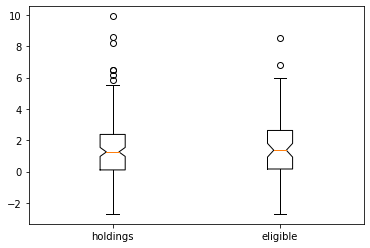

In [16]:
plt.figure()

plt.boxplot([list_of_coef_holdings, list_of_coef_eligible], "y")
plt.xticks(ticks=[1,2], labels=["holdings", "eligible"])

plt.show()

This figure shows us that only roughly 25% of companies have a negative slope, while the other 75% have an increasin ESG score.

Let us now try to find a relation between the initial ESG score and the most recent one. This can be done by plotting and calculating the covariance matrix.

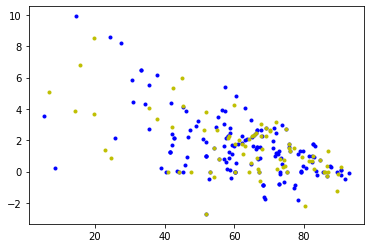

In [17]:
plt.figure()

plt.plot(list_of_intercepts_holdings,list_of_coef_holdings, 'b.')
plt.plot(list_of_intercepts_eligible,list_of_coef_eligible, 'y.')

plt.show()

In [18]:
print("holdings:\n", np.corrcoef(list_of_coef_holdings, list_of_intercepts_holdings),
      "\n eligible:\n", np.corrcoef(list_of_coef_eligible, list_of_intercepts_eligible))

holdings:
 [[ 1.         -0.54811866]
 [-0.54811866  1.        ]] 
 eligible:
 [[ 1.         -0.58874652]
 [-0.58874652  1.        ]]


There seems to be some negative correlation ==> lower initial value, faster increase in ESG score.

### ESG Evolution of holdings through the years

In [102]:
esg_company_data_holdings_with_years = years_issuer_bought.merge(esg_company_data_holdings,"inner","ISSUER")

esg_scores_per_year = {'2015':[],'2016':[],'2017':[],'2018':[],'2019':[],'2020':[],'2021':[]}

for index,row in esg_company_data_holdings_with_years.iterrows():
    years = row["YEARS"]
    for year in years:
        year = str(year)
        esg_scores_per_year[year].append(row["ESG Score "+year])

In [115]:
average_esg_per_year = []
std_esg_per_year = []
for key in esg_scores_per_year.keys():
    average_esg_per_year.append(np.mean(esg_scores_per_year[key]))
    std_esg_per_year.append(np.std(esg_scores_per_year[key]))

C:\Users\Maarten\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Maarten\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Maarten\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Maarten\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\Maarten\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


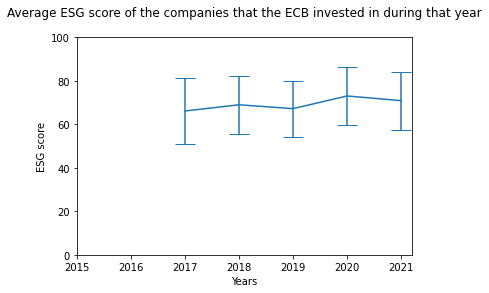

In [124]:
plt.figure()

years = range(2015,2022)

plt.errorbar(x=years,y=average_esg_per_year,yerr=std_esg_per_year,capsize=10)

plt.title("Average ESG score of the companies that the ECB invested in during that year\n")
plt.xlabel("Years")
plt.ylabel("ESG score")
plt.xticks(years)
plt.ylim(0,100)

plt.show()